In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Считайте данные и выведите первые 5 строк
df = pd.read_csv('14 bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):

- season: 1 - весна, 2 - лето, 3 - осень, 4 - зима
- yr: 0 - 2011, 1 - 2012
- mnth: от 1 до 12
- holiday: 0 - нет праздника, 1 - есть праздник
- weekday: от 0 до 6
- workingday: 0 - нерабочий день, 1 - рабочий день
- weathersit: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
- temp: температура в Цельсиях
- atemp: температура по ощущениям в Цельсиях
- hum: влажность
- windspeed(mph): скорость ветра в милях в час
- windspeed(ms): скорость ветра в метрах в секунду
- cnt: количество арендованных велосипедов (это целевой признак, его мы будем
предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них
можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с
вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой
признак зависит от остальных

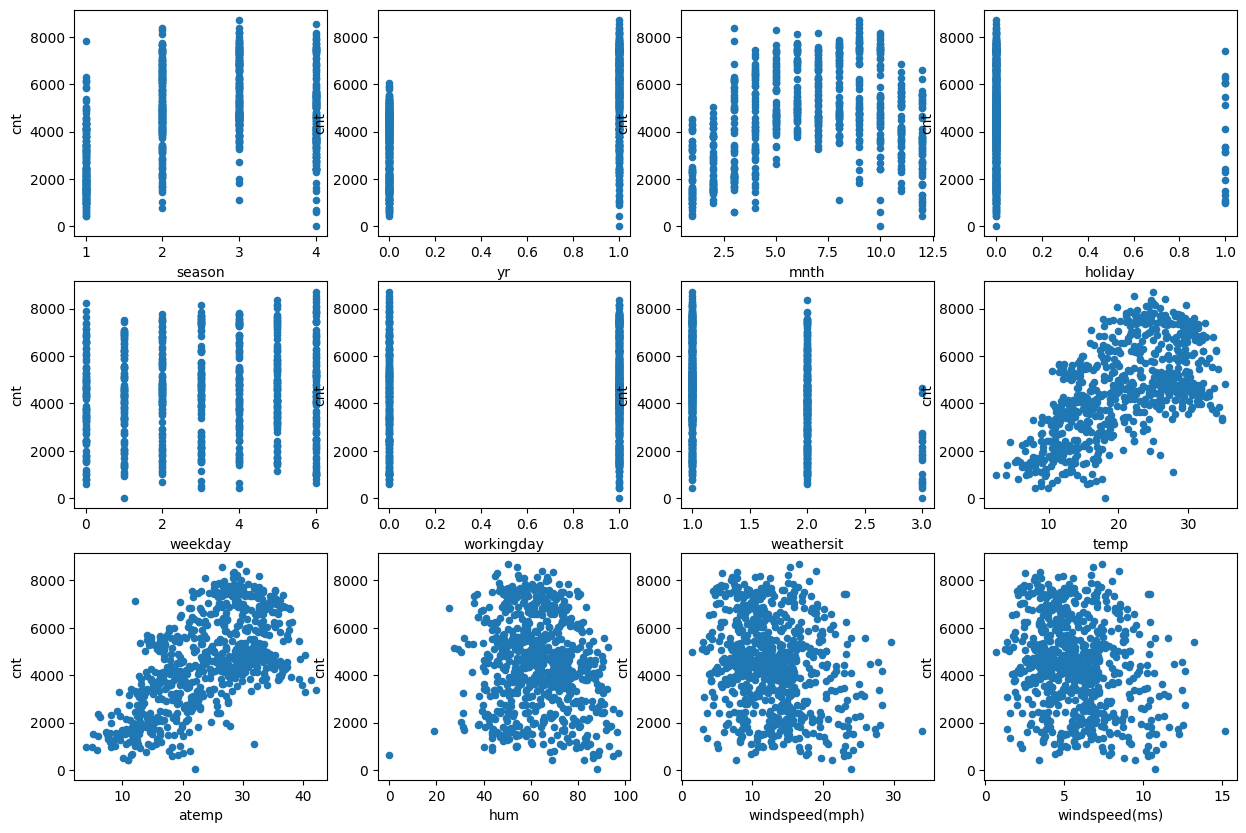

In [3]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
  df.plot(feature, 'cnt', subplots=True, kind='scatter', ax=axes[idx // 4, idx % 4])

Блок 1. Ответьте на вопросы (каждый 0.5 балла):
1. Каков характер зависимости числа прокатов от месяца?
> Ответ: В летние месяцы количество прокатов увеличивается. Наибольшее количество прокатов достигается в 9 месяце (сентябрь), а после идет снижение.

2. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно.
> Ответ: temp

Давайте более строго оценим уровень линейной зависимости между признаками и целевой
переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция
Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод
df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать
еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между
признаками из df и этого датафрейма.

In [4]:
# Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith
df.iloc[:, :-1].corrwith(df['cnt'])

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

In [5]:
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), win dspeed(ms) и cnt
# с помощью метода corr
df.loc[:, ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


In [6]:
# Выведите средние признаков
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем
его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.
Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [7]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression

In [8]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled['cnt']
X.shape, y.shape

((731, 12), (731,))

In [9]:
# Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели
# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python
# Названия признаков хранятся в переменной df.columns
model = LinearRegression()
model.fit(X, y)
pairs = zip(df.columns, model.coef_)
for pair in pairs:
  print('{:10}\t{:10}'.format(pair[0], pair[1]))

season    	570.8676440049306
yr        	1021.9699495253712
mnth      	-141.3032890062043
holiday   	-86.75936596683086
weekday   	137.22540434438187
workingday	56.3900074927935
weathersit	-330.23250386355534
temp      	367.4504868270867
atemp     	585.578995872298
hum       	-145.60658379279874
windspeed(mph)	12456721298309.049
windspeed(ms)	-12456721298507.502


Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами
решилась.

In [10]:
from sklearn.linear_model import Lasso, Ridge

In [11]:
# Обучите линейную модель с L1-регуляризацией
l1_model = Lasso()
l1_model.fit(X, y)
pairs = zip(df.columns, l1_model.coef_)
for pair in pairs:
  print('{:10}\t{:10}'.format(pair[0], pair[1]))

season    	560.2416160308866
yr        	1019.4634940657202
mnth      	-128.73062703678733
holiday   	-86.15278133371105
weekday   	137.3478939049632
workingday	55.21237064135662
weathersit	-332.3698569623485
temp      	376.3632362096959
atemp     	576.5307935045537
hum       	-144.1291550034859
windspeed(mph)	-197.13968940249634
windspeed(ms)	-2.803920889847201e-08


In [12]:
# Обучите линейную модель с L2-регуляризацией
l2_model = Ridge()
l2_model.fit(X, y)
pairs = zip(df.columns, l2_model.coef_)
for pair in pairs:
  print('{:10}\t{:10}'.format(pair[0], pair[1]))

season    	563.0645722520177
yr        	1018.9483787875303
mnth      	-131.8733202824771
holiday   	-86.7460979970922
weekday   	138.0051111787191
workingday	55.90311037506477
weathersit	-332.34978849907395
temp      	386.457889191907
atemp     	566.347047060068
hum       	-145.0713272986718
windspeed(mph)	-99.25944108184568
windspeed(ms)	-99.25944115428678


Блок 2. Поясните, каким образом введение регуляризации решает проблему с весами и мультиколлинеарностью.
> Ответ: Регуляризация накладывает ограничения на веса, и таким образом отсекаются алгоритмы с большими весами, что уменьшает мультиколлинеарность.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации (в лекции
коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [13]:
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso (вспомните встроенную в python функцию enumerate),
# а затем обучите Ridge и запишите веса в coefs_ridge.
for id, alpha in enumerate(alphas):
  lasso_model = Lasso(alpha=alpha)
  lasso_model.fit(X, y)
  coefs_lasso[id] = lasso_model.coef_

  ridge_model = Ridge(alpha=alpha)
  ridge_model.fit(X, y)
  coefs_ridge[id] = ridge_model.coef_

Визуализируем динамику весов при увеличении параметра регуляризации:

Text(0.5, 1.0, 'Ridge')

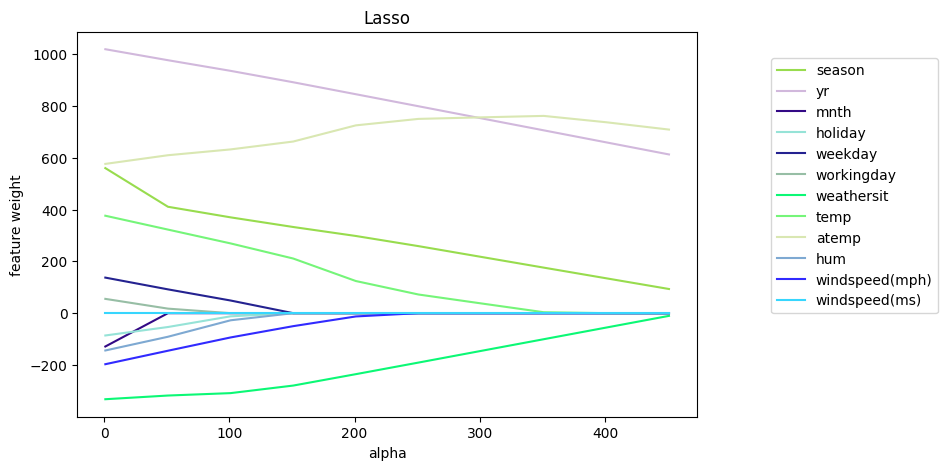

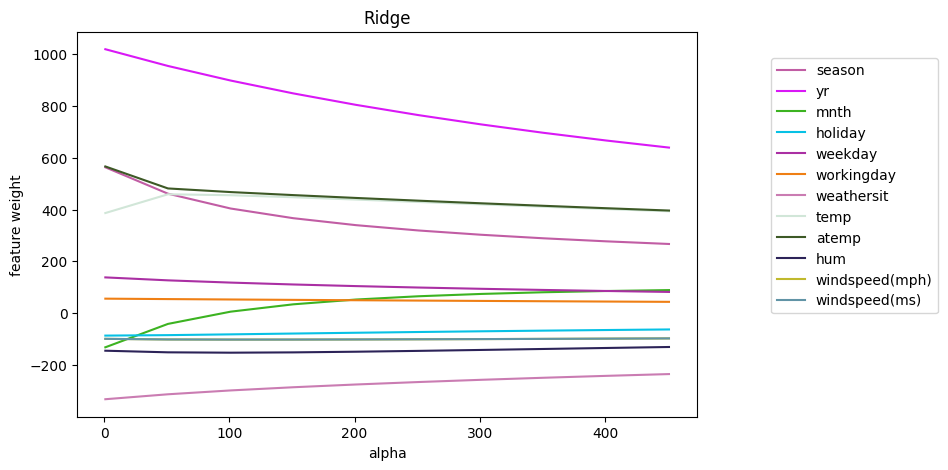

In [14]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
  plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 0.95))
plt.xlabel('alpha')
plt.ylabel('feature weight')
plt.title('Lasso')
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_ridge.T, df.columns):
  plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 0.95))
plt.xlabel('alpha')
plt.ylabel('feature weight')
plt.title('Ridge')

Блок 3. Ответьте на вопросы (каждый 0.25 балла):
1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
> Ответ: Lasso
2. Что произойдет с весами Lasso, если alpha сделать очень большим?  Поясните, почему так происходит.
> Ответ: все веса обнулятся, потому что Lasso постепенно обнуляет веса признаков и при большом alpha сумма модулей весов должна будет стремиться к нулю.
3. Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha > 0? А Ridge? Ситается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.
> Ответ: Lasso исключает один из признаков windspeed при любом значении alpha > 0, а Ridge - нет.
4. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
> Ответ: подойдет Lasso, т.к. он производит отбор признаков и позволяет использовать в модели не все признаки, а только самые важные из них.

In [15]:
from sklearn.linear_model import LassoCV

alpha: 6
season    	532.0189828413543
yr        	1015.0602226430597
mnth      	-100.03952614356685
holiday   	-83.29395987529922
weekday   	132.504465490958
workingday	51.55708561407375
weathersit	-330.5598567399813
temp      	370.679855030035
atemp     	581.3969310654969
hum       	-140.00740550068872
windspeed(mph)	-191.77140847136064
windspeed(ms)	-2.684434701461809e-08


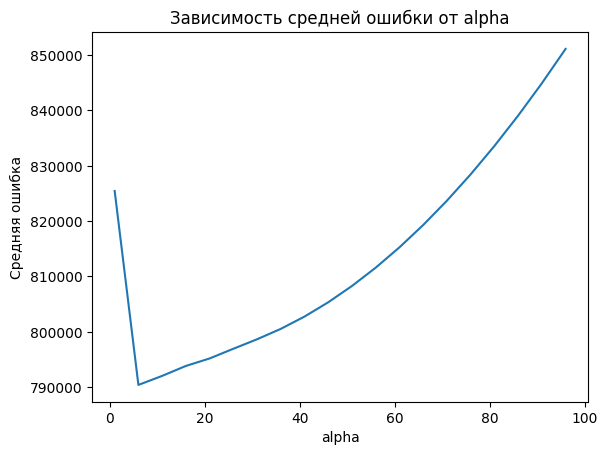

In [17]:
# Обучите регрессор LassoCV на всех параметрах регуляризации из alpha
# Постройте график _усредненного_ по строкам MSE в зависимости от alpha.
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
alphas = np.arange(1, 100, 5)
lassocv_model = LassoCV(n_alphas=len(alphas), alphas=alphas, cv=3)
lassocv_model.fit(X, y)

mean_errors = lassocv_model.mse_path_.mean(axis=1)
plt.plot(lassocv_model.alphas_, mean_errors)
plt.xlabel('alpha')
plt.ylabel('Средняя ошибка')
plt.title('Зависимость средней ошибки от alpha')

print(f'alpha: {lassocv_model.alpha_}')
pairs = zip(df.columns, lassocv_model.coef_)
for pair in pairs:
  print('{:10}\t{:10}'.format(pair[0], pair[1]))

alpha 1: 41, alpha 2: 6, alpha 3: 1


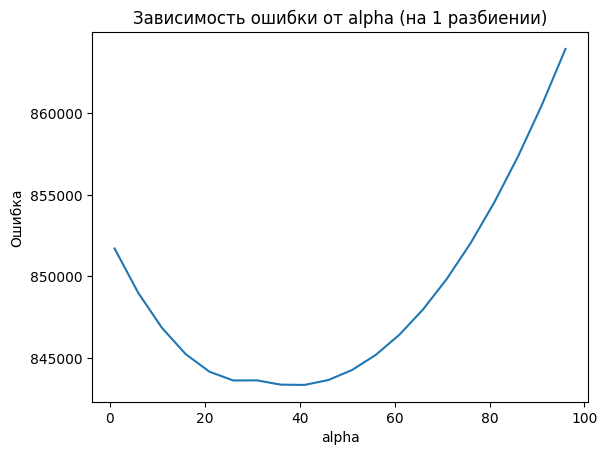

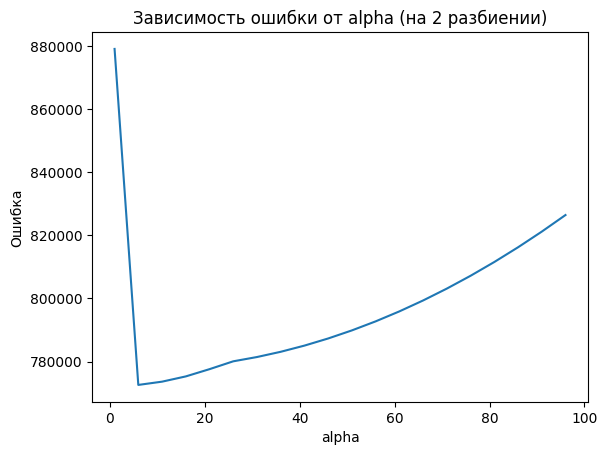

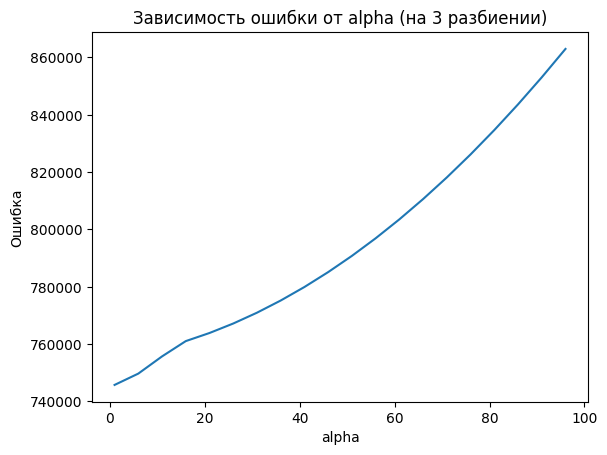

In [18]:
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируйте столбцы .mse_path_
indexes = np.argmin(lassocv_model.mse_path_, axis=0)
print(', '.join(f'alpha {num + 1}: {lassocv_model.alphas_[id]}' for num, id in enumerate(indexes)))

for col_id in range(3):
  col_values = lassocv_model.mse_path_[:, col_id]
  plt.plot(lassocv_model.alphas_, col_values)
  plt.xlabel('alpha')
  plt.ylabel('Ошибка')
  plt.title(f'Зависимость ошибки от alpha (на {col_id + 1} разбиении)')
  plt.show()

Блок 4. Ответьте на вопросы (каждый 0.5 балла):
1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из
здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды?
> Ответ: признаки с наибольшими положительными коэффициентами - yr, atemp, season, temp. По графикам видна возрастающая линейная зависимость от признаков atemp, temp и в какой-то степени yr. Для признака season видно, что летом велосипедов берут больше, чем в другие времена года. Следовательно, логично утверждать, что при повышении температуры (летом), велосипеды берут больше.
1. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
> Ответ: признаки с наибольшими отрицательными коэффициентами - weathersit, windspeed(mph), hum. Для для weathersit убывающая зависимость - меньше людей берут велосипеды в плохую погоду. Для windspeed(mph) и hum тенденция убывающая, но не линейная. Логичено предположить, что при высокой влажности и очень сильном ветре велосипеды берут меньше.
1. Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
> Ответ: признаки с коэффициентами близкими к нулю - windspeed(ms). Данный признак исключен из модели, так как является линейно зависимым от признака windspeed(mph). Он влияет на спрос ровно так же, как и windspeed(mph), а в двух сильнокоррелирующих признаках нет смысла, это ведет к мультиколлинеарности.